In [ ]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

# uses the CAMB cosmology which produced the cls
import camb
from cosmology import Cosmology
import glass
import glass.ext.camb


In [ ]:
nside=256
freqs=np.arange(544,1088,step=10) #instead of steps of1MHz use 10
nfreqs=len(freqs)
lmax=3*nside -1

# creating a numpy random number generator for sampling
rng = np.random.default_rng(seed=42)

# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(
    H0=100 * h,
    omch2=Oc * h**2,
    ombh2=Ob * h**2,
    NonLinear=camb.model.NonLinear_both,
)

In [ ]:
z_f= (1420/544)-1
z_i= (1420/1087)-1

print(z_i, z_f)

0.30634774609015647 1.6102941176470589


In [ ]:
def compute_matter_cls_corr(z_i:float, z_f: float, nfreq: int, lmax:int):
    """
    Compute the matter angular power spectrum using CAMB with correlations between shells.
    
    Parameters:
    z_i (float): Initial redshift.
    z_f (float): Final redshift.
    nfreqs (int): Number of frequency channels.
    lmax (int): Maximum multipole.
    
    Returns:
    cls: Angular power spectrum
    """
    zb=glass.redshift_grid(z_i, z_f, num=nfreq)

    # triangular radial windows, equivalent to linear interpolation of n(z)
    shells = glass.linear_windows(zb, dz=0.1*(z_f-z_i)/nfreq)
    
    # compute angular matter power spectra with CAMB
    cls = glass.ext.camb.matter_cls(pars, lmax, shells)
    
    return shells, cls

In [ ]:
shells_i, cls_hi=compute_matter_cls_corr(z_i,z_f, nfreqs, lmax)
print(len(cls_hi))

/tmp/ipykernel_2164289/1021660912.py:17: UserWarning: first triangular window does not start at z=0
  shells = glass.linear_windows(zb, dz=0.1*(z_f-z_i)/nfreq)


1485


In [ ]:
cls_healpix=glass.glass_to_healpix_spectra(cls_hi)

In [ ]:
idx= glass.spectra_indices(len(shells_i))
x,y=idx[5]
print(x)
print(y)
print(len(idx))

2
0
1485


In [ ]:
# Initialize the array to store the full spectra
cls_full = np.zeros((nfreqs, nfreqs, lmax + 1))

# Loop over index pairs (i, j)
for pair in idx:
    i, j = pair  # unpack the pair
    cl_ij = glass.getcl(cls_healpix, i, j)  # get the C_l^{ij} spectrum
    cls_full[i, j, :] = cl_ij
    if i != j:
        cls_full[j, i, :] = cl_ij  # fill the symmetric entry

print(cls_full.shape) #C_l{ij} in GLASS ordering

(55, 55, 768)


In [ ]:
ells=np.arange(0, lmax+1)

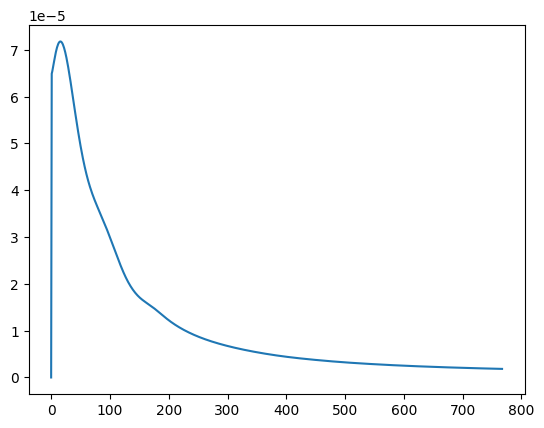

In [ ]:
plt.plot(ells,cls_full[0, 3, :])

In [ ]:
cov=glass.cov_from_spectra(cls_hi,lmax=lmax)

In [ ]:
cov.shape

(768, 54, 54)

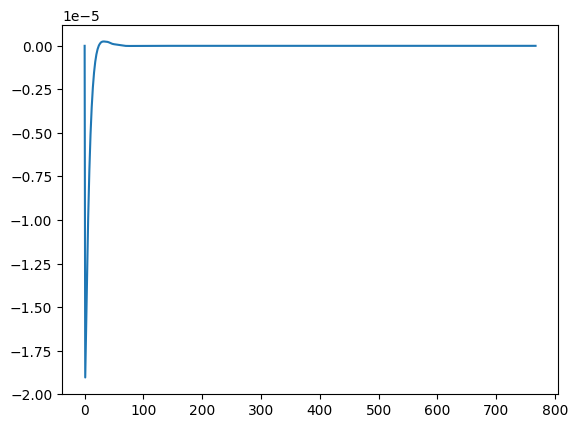

In [ ]:
plt.plot(ells,cov[:,0,3])

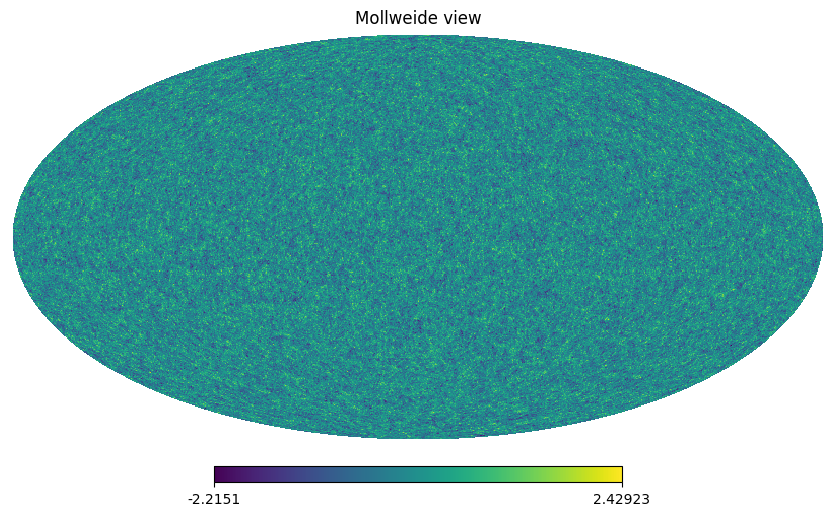

In [ ]:
hp.mollview(hp.synfast(cls_full[0,3,:], nside))